# CS2420: Assignment 2



> Harvard CS 2420: Computing at Scale (Fall 2024)
>
> Instructor: Professor HT Kung


### **Assignment Instructions**

Read the following instructions carefully before starting the assignment and again before submitting your work:

* This programming assignment must be completed in a team of 3-4 students.  **If you do not have a three or four person group, please email Andrew (asabot@g.harvard.edu) immediately.**
* **We suggest you start right away.** While you will only need to write around **30 lines or fewer of code** per code cell, we expect this assignment to take **3-7 days** of significant effort for a group of three to four (training the networks takes a long time, so don't start at the last second).
* The assignment consists of two files: **this Google Colab file** (an `.ipynb` file) and a **LaTeX answer template** (available on Canvas).
* The Google Colab contains all assignment instructions and *Code Cells* that you will use to implement the programming components of the assignment (in Python).
* We provide a significant amount of the code to make it easier to get started. In the *Code Cells*, please add comments to explain the purpose of each line of code in your implementation. **You will not receive credit for implementations that are not well documented.**
* <font color='red'>**Deliverables are highlighted in red**</font> in this Google Colab file. Use the LaTeX answer template to write down answers for these deliverables.
* Each group will **submit** a PDF of your answers, any logs from generative AI, and your Google Colab file (.ipynb file) containing all completed *Code cells* to "Programming Assignment 2" on Canvas. Only one submission per group. Check your .ipynb file using this [tool](https://htmtopdf.herokuapp.com/ipynbviewer/) before submitting to ensure that you completed all *Code Cells* (including detailed comments).
* The assignment is due on **10/9/2024 at 11:59 PM EST**.


-----
Outline of this assignment:

1. **Getting Started** [15 points]: In this section, you will train a convolutional neural network in PyTorch on the CIFAR-10 image classification dataset. This section will introduce you to the PyTorch machine learning library and training neural networks.


2. **Post-training Quantization** [15 points]: In this section, you will perform post-training quantization of weights on a small fully-connected neural network trained on the MNIST classification dataset. This section reinforces your understanding of quantization and will give you a concrete understanding of the limitations of quantization.

3. **Conv Pruning** [60 points]:  In this section, you will implement a simplified version of structured filter pruning based on [Pruning Filters for Efficient ConvNets](https://openreview.net/pdf?id=rJqFGTslg) and non-structured pruning based on [Learning both Weights and Connections for Efficient Neural Networks
](https://arxiv.org/abs/1506.02626).

4. **Parameter Efficient Fine-tuning** [35 points]: In this section, you will fine-tune a ResNet-18 model using three methods for updating the model: 1) updating all of the models parameters 2) freezing earlier layers and updating the later layers 3) a combinations of frozen layers and low rank updates based on [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/pdf/2106.09685.pdf).

5. **Transformer Architecture** [35 points]: In this section, you will be implementing the individual components of the transformer model based on the paper [Attention is All You Need](https://arxiv.org/abs/1706.03762). This section will provide further intuition on the attention mechanism and provide you a high-level overview of how data flows through the transformer model.

---

### **1. Getting Started**

---
First, make a copy of this Google Colab by navigating to `File->Save a copy in Drive`. Share the copy with all other group members. You will modify the *Code Cells* in your new copy to complete the assignment.


While you are reading through the material, please execute each code cell in order, by either selecting the code cell and pressing the play symbol (▶) on the left side of the code cell or by using the hotkey combination: Shift + Enter.

It's important to note that simultaneously running the same Colab notebook on different computers can introduce version conflicts. One method to overcome this is to assign a person in your group to control the notebook while others work on another (copied) notebook to test out their code.


*Code Cell 1.0* imports libraries used throughout the assignment and *Code Cell 1.1* defines model testing and training functions. We recommend reading through and understanding *Code Cell 1.1* before working through the rest of the assignment.

In [ ]:
# nvidia-smi allows you to check if a GPU device has been enabled in Colab
!nvidia-smi

# If you did not see a GPU device after running the above command, go to:
# 'Runtime --> Change runtime type --> Hardware accelerator' and select 'gpu'.
# Then, click 'Runtime --> restart runtime'.

# You should use a GPU device for training models as it will *significantly*
# accelerate training compared to using a CPU device.

Wed Oct  9 02:45:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
#@title Code Cell 1.0: Imports

import sys
import time
import os
import math

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from copy import deepcopy

from torch.autograd import Variable

In [ ]:
#@title Code Cell 1.1: Training/Test Functions

# tracks the highest accuracy observed so far
best_acc = 0

def moving_average(a, n=100):
    '''Helper function used for visualization'''
    ret = torch.cumsum(torch.Tensor(a), 0)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def train(net, epoch, loader, criterion, optimizer, loss_tracker = [], acc_tracker = []):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        # update optimizer state
        optimizer.step()
        # compute average loss
        train_loss += loss.item()
        loss_tracker.append(loss.item())
        loss = train_loss / (batch_idx + 1)
        # compute accuracy
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        # Print status
        sys.stdout.write(f'\rEpoch {epoch}: Train Loss: {loss:.3f}' +
                         f'| Train Acc: {acc:.3f}')
        sys.stdout.flush()
    acc_tracker.append(acc)
    sys.stdout.flush()

def test(net, epoch, loader, criterion, loss_tracker = [], acc_tracker = []):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            loss_tracker.append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
    sys.stdout.write(f' | Test Loss: {loss:.3f} | Test Acc: {acc:.3f}\n')
    sys.stdout.flush()

    # Save checkpoint.
    acc = 100.*correct/total
    acc_tracker.append(acc)
    if acc > best_acc:
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

**Loading the Train and Test Datasets**

For this assignment, we will use the CIFAR-10 dataset. It contains 10 object classes, where each sample is a color image (RGB channels) with a spatial resolution of 32 x 32 pixels. More details here: https://www.cs.toronto.edu/~kriz/cifar.html. *Code Cell 1.2* will take 1-2 minutes to execute as it downloads the training and test datasets.

In [ ]:
#@title Code Cell 1.2

# Load training data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,
                                        transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

# Load testing data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,
                                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False,
                                         num_workers=2)
print('Finished loading datasets!')

100%|██████████| 170498071/170498071 [00:06<00:00, 28108809.23it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Finished loading datasets!


**Constructing our Convolutional Neural Network (CNN)**

For this assignment, we will use a 10-layer CNN which we call `ConvNet` that is provided in *Code Cell 1.3*. The CNN has 9 convolutional layers (`nn.Conv2d`) followed by 1 fully connected (`nn.Linear`) layer. The Batch Normalization layers (`nn.BatchNorm2d`) help make the training process more stable and the ReLU layers (`nn.ReLU`) are the non-linear activation functions required for learning when stacking multiple convolutional layers together.

In this assignment, you will modify `ConvNet` to implement Depthwise Separable Convolutions (Section 2) and Pruning (Section 4).

In [ ]:
#@title Code Cell 1.3

def conv_block(in_channels, out_channels, kernel_size=3, stride=1,
               padding=1):
    '''
    A nn.Sequential layer executes its arguments in sequential order. In
    this case, it performs Conv2d -> BatchNorm2d -> ReLU. This is a typical
    block of layers used in Convolutional Neural Networks (CNNs). The
    ConvNet implementation below stacks multiple instances of this three layer
    pattern in order to achieve over 90% classification accuracy on CIFAR-10.
    '''
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

class ConvNet(nn.Module):
    '''
    A 9 layer CNN using the conv_block function above. Again, we use a
    nn.Sequential layer to build the entire model. The Conv2d layers get
    progressively larger (more filters) as the model gets deeper. This
    corresponds to spatial resolution getting smaller (via the stride=2 blocks),
    going from 32x32 -> 16x16 -> 8x8. The nn.AdaptiveAvgPool2d layer at the end
    of the model reduces the spatial resolution from 8x8 to 1x1 using a simple
    average across all the pixels in each channel. This is then fed to the
    single fully connected (linear) layer called classifier, which is the output
    prediction of the model.
    '''
    def __init__(self):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 32),
            conv_block(32, 64, stride=2),
            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 128, stride=2),
            conv_block(128, 128),
            conv_block(128, 256),
            conv_block(256, 256),
            nn.AdaptiveAvgPool2d(1)
            )

        self.classifier = nn.Linear(256, 10)

    def forward(self, x):
        '''
        The forward function is called automatically by the model when it is
        given an input image. It first applies the 8 convolution layers, then
        finally the single classifier layer.
        '''
        h = self.model(x)
        B, C, _, _ = h.shape
        h = h.view(B, C)
        return self.classifier(h)

**Training ConvNet on the CIFAR-10 Dataset**

Now that we have loaded our training and testing datasets, and created our model, it is time to train the model. This training process will take around 15 seconds per epoch (an epoch is an entire pass through the training dataset). Usually, we need to train models for many epochs in order to achieve good classification accuracy. For this assignment, we will train most models for 100 epochs. This means that the training process takes roughly 15 seconds * 100 = 25 minutes. **Please do not close or refresh the Colab instance during training and make sure to export results if you plan on using them in the future.** Note that the Google Colab instance is non-persistent, so if the session is left idle for a period of time (such as 30-minutes), the state of the machine will be lost. When this happens, you must execute all Code Cells, in order, up to your current point of progress. To avoid this, you may want to ensure that your session is kept alive by not leaving it idle.

*Code Cell 1.4* provides a `train` function that will perform one epoch worth of training each time it is called. The `test` function will evaluate the performance of the model on the held-out test set.


---
<font color='red'>**PART 1.1:**</font> [5 points]

<font color='red'>**Deliverables**</font>
1. In *Code Cell 1.4*, set the number of epochs (`epochs`) to `5`. Train the model 3 separate times, with learning rate (`lr`) set to `0.0001`, `0.1`, and `1.0`.
2. For each model run over 5 epochs, plot the training loss (`train_loss_tracker`) and test accuracy (`test_acc_tracker`). For the training loss, apply the provided `moving_average` function on `train_loss_tracker` before plotting to smooth out the loss curve.

3. Plot the training loss and test accuracy for each run with the different learning rates `0.0001`, `0.1`, and `1.0`. (x-axis is epoch)
4. Describe the difference in trends for each learning rate run. Which learning rate seemed to work best? Explain why you think it did best relative to the other learning rates. (100 words maximum)
---


<font color='red'>**PART 1.2:**</font> [10 points]
* Set the learning rate (`lr`) to the best setting observed in <font color='red'>**PART 1.1**</font>.
* Change the number of epochs (`epochs`) from `5` to `100`.

Since you are training the model for 100 epochs, it will take roughly 25-30 minutes to complete. We use a deterministic random seed for weight initialization to remove variability between runs.

Adjusting the learning rate during training is a common strategy used to improve the final accuracy of the CNN. We will compare two different methods (*MultiStep* and *CosineAnnealing*) to adjust the learning rate.  
Please check the PyTorch documentation for [MultiStepLR](https://pytorch.org/docs/stable/optim.html?highlight=multistep#torch.optim.lr_scheduler.MultiStepLR) and [CosineAnnealingLR](https://pytorch.org/docs/stable/optim.html?highlight=cosineannealinglr#torch.optim.lr_scheduler.CosineAnnealingLR) to determine how to use them.

<font color='red'>**Deliverables**</font>


1. First try the [MultiStepLR](https://pytorch.org/docs/stable/optim.html?highlight=multistep#torch.optim.lr_scheduler.MultiStepLR) learning rate scheduler. Set `lr_scheduler` (*Line 96 in Code Cell 1.4*) as 'multistep'. In addition, you also need to set the milestones (`milestones`) used in the scheduler to decrease the learning rate by a factor of 10 every 25 epochs. Train the network for 100 epochs and plot the training loss and test accuracy.
2. Then try the [CosineAnnealingLR](https://pytorch.org/docs/stable/optim.html?highlight=cosineannealinglr#torch.optim.lr_scheduler.CosineAnnealingLR) learning rate scheduler. Set `lr_scheduler` (*Line 96 in Code Cell 1.4*) as 'cosine_annealing'. Train the network for 100 epochs and plot the training loss and test accuracy (where the x-axis is the number of epochs).
3. Describe the trends of the learning curves with *MultiStep* and *CosineAnnealing* respectively. (50 words maximum)
4. Record and report the provided total running time.
---


In [ ]:
#@title Code Cell 1.4

torch.manual_seed(43) # to give stable randomness

device = 'cuda'
net = ConvNet()
net = net.to(device)

# PART 1.1: set the learning rate (lr) used in the optimizer.
lr = 1.0

# PART 1.1: Modify this to train for a short 5 epochs
# PART 1.2: Modify this to train a longer 100 epochs
epochs = 100

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                            weight_decay=5e-4)

# PART 1.2: try different learning rate scheduler
scheduler_name= 'cosine_annealing'   # set this to 'multistep' or 'cosine_annealing'
if scheduler_name=='multistep':
    milestones = range(0, epochs, 25)
    gamma = 0.1
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                    milestones=milestones,
                                                    gamma=gamma)
elif scheduler_name=='cosine_annealing':
    milestones = None
    gamma = None
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
else:
    NotImplementedError

# Records the training loss and training accuracy during training
train_loss_tracker, train_acc_tracker = [], []

# Records the test loss and test accuracy during training
test_loss_tracker, test_acc_tracker = [], []

print('Training for {} epochs, with learning rate {} and milestones {}'.format(
      epochs, lr, milestones))

start_time = time.time()
for epoch in range(0, epochs):
    # train(net, epoch, train_loss_tracker, train_acc_tracker, trainloader)
    # test(net, epoch, test_loss_tracker, test_acc_tracker, testloader)
    train(net=net, epoch=epoch, loader=trainloader, criterion=criterion, optimizer=optimizer, loss_tracker=train_loss_tracker, acc_tracker=train_acc_tracker)
    test(net=net, epoch=epoch, loader=testloader, criterion=criterion, loss_tracker=test_loss_tracker, acc_tracker=test_acc_tracker)
    scheduler.step()

total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))

Training for 5 epochs, with learning rate 1.0 and milestones None
Epoch 0: Train Loss: 2.051| Train Acc: 22.218 | Test Loss: 2.084 | Test Acc: 24.730
Epoch 1: Train Loss: 1.751| Train Acc: 34.050 | Test Loss: 2.072 | Test Acc: 26.910
Epoch 2: Train Loss: 1.482| Train Acc: 45.628 | Test Loss: 1.660 | Test Acc: 42.020
Epoch 3: Train Loss: 1.186| Train Acc: 57.362 | Test Loss: 2.081 | Test Acc: 39.440
Epoch 4: Train Loss: 0.877| Train Acc: 69.098 | Test Loss: 1.525 | Test Acc: 54.050
Total training time: 128.84249544143677 seconds


In [ ]:
# plotting code for cosine annealing
fig = plt.figure(figsize=(6,8))
fig.tight_layout()
fig.suptitle("CosineAnnealingLR Run with Learning Rate 1", y=1, fontweight="bold")
fig.subplots_adjust(top=0.95,hspace=0.4)

ax1 = fig.add_subplot(3, 1, 1)
ax1.title.set_text("Training Loss")
ax1.yaxis.set_label_text("Loss (bits)")
ax1.xaxis.set_label_text("Sample by Epoch")
ax1.plot(train_loss_tracker, label="Original")
ax1.plot(moving_average(train_loss_tracker), color='r', label="Averaged Line") # 1.1.2 info
ax1.legend()

ax2 = fig.add_subplot(3,1,2)
ax2.title.set_text("Average Training Loss per Epoch")
# train_loss_tracker contains the loss for every sample per epoch,
averages = []
dataset_elements_num = 391
for i in range(0, len(train_loss_tracker), dataset_elements_num):
    if i + dataset_elements_num <= len(train_loss_tracker):
        avg = sum(train_loss_tracker[i:i+dataset_elements_num]) / dataset_elements_num
        averages.append(avg)
ax2.plot(averages)
ax2.yaxis.set_label_text("Loss (bits)")
ax2.xaxis.set_label_text("Epoch")
ax3 = fig.add_subplot(3, 1, 3)
ax3.title.set_text("Test Accuracy")
ax3.yaxis.set_label_text("Accuracy (%)")
ax3.xaxis.set_label_text("Epoch")
ax3.plot(test_acc_tracker);

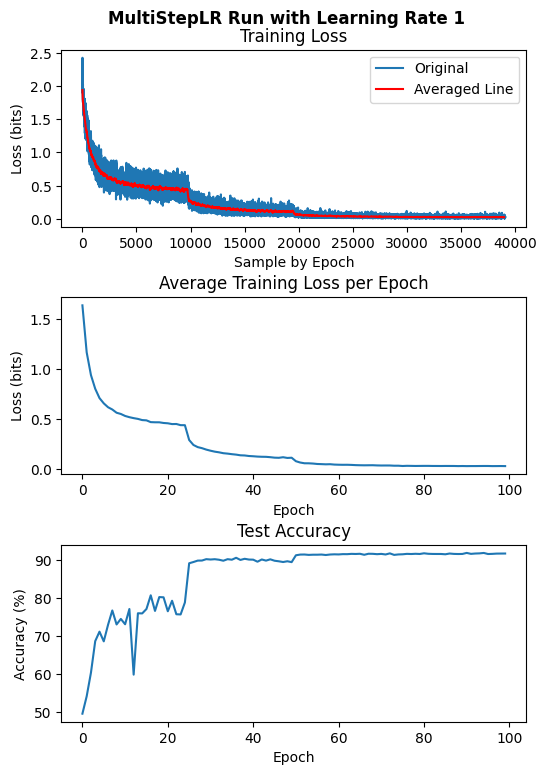

In [ ]:
# plotting code for multistep
fig = plt.figure(figsize=(6,8))
fig.tight_layout()
fig.suptitle("MultiStepLR Run with Learning Rate 1", y=1, fontweight="bold")
fig.subplots_adjust(top=0.95,hspace=0.4)

ax1 = fig.add_subplot(3, 1, 1)
ax1.title.set_text("Training Loss")
ax1.yaxis.set_label_text("Loss (bits)")
ax1.xaxis.set_label_text("Sample by Epoch")
ax1.plot(train_loss_tracker, label="Original")
ax1.plot(moving_average(train_loss_tracker), color='r', label="Averaged Line") # 1.1.2 info
ax1.legend()

ax2 = fig.add_subplot(3,1,2)
ax2.title.set_text("Average Training Loss per Epoch")
# train_loss_tracker contains the loss for every sample per epoch,
averages = []
dataset_elements_num = 391
for i in range(0, len(train_loss_tracker), dataset_elements_num):
    if i + dataset_elements_num <= len(train_loss_tracker):
        avg = sum(train_loss_tracker[i:i+dataset_elements_num]) / dataset_elements_num
        averages.append(avg)
ax2.plot(averages)
ax2.yaxis.set_label_text("Loss (bits)")
ax2.xaxis.set_label_text("Epoch")
ax3 = fig.add_subplot(3, 1, 3)
ax3.title.set_text("Test Accuracy")
ax3.yaxis.set_label_text("Accuracy (%)")
ax3.xaxis.set_label_text("Epoch")
ax3.plot(test_acc_tracker);

---

### **2. Post-training Quantization**

---

In this section, you will perform post-training quantization of weights on a multi-layer perceptron with fully connected layers to reduce its memory requirements.
We will start by training a small neural network on the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Then, we will quantize its weights and verify that performance does not degrade significantly.

In [ ]:
#@title Code Cell 2.1

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# Run this code cell to train MNIST neural network. Do not modify!
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

# Train an MNIST neural network. Run this code cell.
class MNISTNet(nn.Module):
    def __init__(self, hidden=128):
      super(MNISTNet, self).__init__()

      # First 2D convolutional layer, taking in 1 input channel (image),
      # outputting 32 convolutional features, with a square kernel size of 3
      self.hidden = hidden
      self.fc1 = nn.Linear(28*28*1, self.hidden)
      self.fc2 = nn.Linear(self.hidden, 10)

    def forward(self, x):
      x = x.view(-1, 28*28)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      return F.log_softmax(x, dim=1)

def train_mnist(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test_mnist(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

model = MNISTNet()
device = torch.device("cpu")

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1_mnist = datasets.MNIST('./data_mnist', train=True, download=True,
                    transform=transform)
dataset2_mnist = datasets.MNIST('./data_mnist', train=False,
                    transform=transform)
train_loader_mnist = torch.utils.data.DataLoader(dataset1_mnist)
test_loader_mnist = torch.utils.data.DataLoader(dataset2_mnist)

optimizer = optim.Adam(model.parameters())

scheduler = StepLR(optimizer, step_size=1, gamma=.1)
for epoch in range(1, 5):
    train_mnist(model, device, train_loader_mnist, optimizer, epoch)
    test_mnist(model, device, test_loader_mnist)
    scheduler.step()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.167863
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.000432
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.000000
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.000121
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.000003
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.000014

Test set: Average loss: 0.2585, Accuracy: 9420/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.000345
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.000000
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.000000
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.000003
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.000000
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.000004

Test set: Average loss: 0.1277, Accuracy: 9694/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.002207
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.000000
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.000000
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.000003
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.000000
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.

---
<font color='red'>**PART 2.1:**</font> [5 points]

We will perform post-training quantization on the weights of a neural network. Recall from lecture that quantization maps high-precision values to low-precision values to reduce the number of bits used to store each value. In this section you will implement two functions:
* **quantize**: compresses a vector/matrix from 32-bit float to 8-bit integer
* **dequantize**: takes the output of **quantize** and recovers the original values (possibly with some error).

**Quantization Example**

Given a vector of 32-bit floats containing the values `[400, 500, 600]`, our goal is to quantize these values so that they are representable in 8 bits. With 8 bits, we can only represent the values 0 through 255 -- but we have a problem: 400, 500 and 600 are outside of this range! To solve this, we want to map the values of the vector such that each value is *approximately* representable by values between 0 and 255. To do this we:
1. Shift the vector so that the minimum value is 0
2. Scale the vector so that every value is between 0 and 255
3. Cast each value to an (8-bit) integer

For example, suppose we are quantizing `v=[400,500,600]`.
* After shifting would have `shift=400`, `v_shifted=[0,100,200]`.
* After scaling, we would have `scale=255/200`, `shift=400`, `v_shifted_scaled=[0*255/200, 100 *255/200, 200 *255/200] = [0, 127.5, 255]`, giving us `v_q=[0, 128, 255]` after rounding.

With this process we have successfully quantized the elements of `v` to be representable by 8 bits (with additional `scale` and shift `parameters`). This yields ~4x reduction in size for large vectors!

**Dequantization Example**

To dequantize, we do the opposite:
* Given: `v_q=[0,128,255]`, `shift=400`, `scale=255/200`
* Reverse scale: `v_unscaled = v_q / scale = [0, 100.392, 200]`
* Reverse shift: `v_unscaled + 400 = [400, 500.392, 600]`

As you can see, our dequantized values are very close to our original values (`[400,500,600]`), but there is some quantization error due to loss of information during quantization. As you will see in the next section, neural networks may tolerate these errors and still attain high accuracy.

<font color='red'>**Deliverables**</font>

1. In *Code Cell 2.2*, implement the `quantize` function, which takes a 1D or 2D NumPy array and quantizes each element to be representable with 8 bits (i.e., with an integer value between 0 and 255). The function should return a NumPy array with `dtype=uint8`. Keep in mind that the quantized values will need to be dequantized (converted back to a non-quantized form), so you may also return any other value you may find useful for dequantization.

2. In *Code Cell 2.2*, implement the `dequantize` function which takes in a NumPy array with `dtype=uint8` (and any other parameters you think necessary), and attempts to recover the values from before quantization. Because quantizing to 8 bits loses information, you may not necessarily obtain the exact weight values from before quantization. Ideally, the quantization error is small enough to maintain good inference accuracy.

3. In *Code Cell 2.2*, verify that both your `quantize` and `dequantize` functions work by making sure it passes the test case. The test case checks that your quantization function achieves a 4x reduction in memory and asserts that the dequantized data is within some error threshold of the original matrix. You should see "Success!" if your method passes a test case.

4. How much smaller (in bits) is the quantized data than the original? (Remember to account for the extra arguments you added!) Is it 4x? If not, why might this be? (50 words maximum)


In [ ]:
#@title Code Cell 2.2

import numpy as np
import sys

def quantize(W):
    # PART 2.1: Implement!
    # Hint: you may return extra parameters
    # Hint: our solution is 3-5 lines of code
    shift = np.min(W)
    scale = 255 / (np.max(W) - shift)
    data = (W - shift) * scale
    return data.astype(np.uint8), [scale, shift]


def dequantize(W, extra_args):
    # PART 2.1 Implement!
    # Hint: you may pass extra args through the extra_args parameter to assist dequantization
    # Hint: our solution is 3-5 lines of code
    return W / extra_args[0] + extra_args[1]

def test_cases():
    def count_bytes(x):
        return sys.getsizeof(x)
    def did_pass(x, thresh=2):
        bytes_original = count_bytes(x.astype(np.float32))
        quantized, args = quantize(x)
        bytes_quantized = count_bytes(quantized)
        dequantized = dequantize(quantized, args)

        smaller = bytes_quantized <= bytes_original//2.3
        mean_err = np.mean(np.abs(dequantized-x))
        accurate = mean_err < thresh

        if not smaller:
            print("FAIL: Size original %d vs quantized %d" % (bytes_original, bytes_quantized))
            return False
        if not accurate:
            print("FAIL: Mean error %f above threshold %f" % (mean_err, thresh))
            return False
        print("Success!")
        return True

    did_pass(np.array([i for i in range(100)]))
    did_pass(np.array([i*.5 for i in range(100)]))
    did_pass(np.random.normal(0, 3, size=(100, 100)))
    did_pass(np.random.uniform(0, 10, size=(100, 100)))
    did_pass(np.random.uniform(5, 10, size=(100, 100)))
    did_pass(np.random.uniform(-5, -10, size=(100, 100)))
    did_pass(np.random.normal(-10, 1, size=(100, 100)))
    did_pass(np.random.uniform(100, 100+255, size=(20, 40)))
test_cases()

Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!


---
<font color='red'>**PART 2.2:**</font> [10 points]

We will now evaluate the performance of the neural network with quantization.

<font color='red'>**Deliverables**</font>

1. Quantize each parameter of the model to 8-bits and dequantize (this injects simulated quantization error into the parameters). Then, create a new model from the dequantized parameters.
2. Evaluate the above model and report the test accuracy. What was the drop in accuracy versus the original full-precision model? (50 words maximum)
3. Quantize to 4 bits instead of 8 and dequantize. What accuracy is achieved from these new 4-bit quantized-and-dequantized parameters? What was the drop in accuracy versus the original full-precision model? (50 words maximum)

In [ ]:
from copy import deepcopy

print("Baseline Score")
test_mnist(model, device, test_loader_mnist)

# PART 2.2: Quantize parameters!
model_q8 = deepcopy(model)
state_dict = model_q8.state_dict()
state_dict_q = {}
quant_params_dict = {}

for key, param in state_dict.items():
    state_dict_q[key], quant_params_dict[key] = quantize(param.cpu().numpy())

for key in state_dict:
    dequantized_param = dequantize(state_dict_q[key], quant_params_dict[key])
    state_dict[key].copy_(torch.from_numpy(dequantized_param))

print("Quantized performance")
test_mnist(model_q8, device, test_loader_mnist)

Baseline Score

Test set: Average loss: 0.1179, Accuracy: 9722/10000 (97%)

Quantized performance

Test set: Average loss: 0.1170, Accuracy: 9715/10000 (97%)



**4-bit quantization**

In [ ]:
# 4 bit quantization

def quantize(W):
    original_shape = W.shape
    W_flat = W.flatten()

    shift = np.min(W_flat)
    scale = 15 / (np.max(W_flat) - shift)
    data = np.round((W_flat - shift) * scale).astype(np.uint8)  # we cast to np.uint8, but these values will range from 0 to 15

    N = data.size
    packed_data = np.zeros((N + 1) // 2, dtype=np.uint8)

    # pack
    for i in range(0, N, 2):
        high_nibble = data[i]
        if i + 1 < N:
            low_nibble = data[i + 1]
        else:
            low_nibble = 0 # pad with zero
        packed_data[i // 2] = (high_nibble << 4) | low_nibble

    return packed_data, [scale, shift, N, original_shape]

def dequantize(W, extra_args):
    scale, shift, N, original_shape = extra_args
    data = np.zeros(N, dtype=np.uint8)

    # unpack
    for i in range(0, N, 2):
        byte = W[i // 2]
        high_nibble = byte >> 4
        low_nibble = byte & 0x0F
        data[i] = high_nibble
        if i + 1 < N:
            data[i + 1] = low_nibble

    W_dequant = data.astype(np.float32) / scale + shift
    W_dequant = W_dequant.reshape(original_shape)
    return W_dequant

print("Baseline Score")
test_mnist(model, device, test_loader_mnist)

model_q4 = deepcopy(model)
state_dict = model_q4.state_dict()
state_dict_q = {}
quant_params_dict = {}

for key, param in state_dict.items():
    state_dict_q[key], quant_params_dict[key] = quantize(param.cpu().numpy())

for key in state_dict:
    dequantized_param = dequantize(state_dict_q[key], quant_params_dict[key])
    state_dict[key].copy_(torch.from_numpy(dequantized_param))

print("Quantized performance")
test_mnist(model_q4, device, test_loader_mnist)

Baseline Score

Test set: Average loss: 0.1179, Accuracy: 9722/10000 (97%)

Quantized performance

Test set: Average loss: 0.1231, Accuracy: 9687/10000 (97%)



---

### **3. Structured and Non-structured Filter Pruning**

---

In this section, you will implement a simplified version of structured filter pruning proposed in [Pruning Filters for Efficient ConvNets](https://openreview.net/pdf?id=rJqFGTslg). Instead of pruning weights, this paper describes removing whole filters from each convolutional layer in a CNN. Compared to pruning weights across the network, filter pruning is a naturally structured pruning method that does not introduce irregular sparsity. Therefore, it does not require using sparse libraries or specialized hardware.
For each convolutional layer, we measure each filter’s relative importance by its absolute weight sum $\sum|\mathcal{F}_{i,j}|$ (i.e., its $\ell_1$-norm). When pruning a layer, $m$ filters with the smallest relative importance will be pruned, where $m$ = (prune percentage $\times$ total number of filters in this layer).

In *Code Cell 3.1*, we provide a `SparseConv2d` layer, which is similar to the standard `nn.Conv2d` layer, but adds a `mask` tensor. The `mask` is used to zero out filters in this layer before the convolution operation is performed. Initially, `mask` is set to all ones, meaning the `SparseConv2d` layer's behavior will be identical to the `nn.Conv2d` layer.

Besides structured pruning, we will also implement non-structured pruning proposed in [Learning both Weights and Connections for Efficient Neural Networks
](https://arxiv.org/abs/1506.02626) for comparsion. Non-structured pruning is more flexible than structured pruning, and allows irregular sparsity in the weight tensor.


In [ ]:
#@title Code Cell 3.1 (original - structured pruning)


def _make_pair(x):
    if hasattr(x, '__len__'):
        return x
    else:
        return (x, x)

class SparseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                     padding=1):
        super(SparseConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = _make_pair(stride)
        self.padding = _make_pair(padding)

        # initialize weights of this layer
        self._weight = nn.Parameter(torch.randn([self.out_channels, self.in_channels,
                                                        self.kernel_size, self.kernel_size]))
        stdv = 1. / math.sqrt(in_channels)
        self._weight.data.uniform_(-stdv, stdv)
        # initialize mask
        # Since we are going to zero out the whole filter, the number of
        # elements in the mask is equal to the number of filters.
        self.register_buffer('_mask', torch.ones(out_channels))


    def forward(self, x):
        return F.conv2d(x, self.weight, stride=self.stride,
                        padding=self.padding)

    @property
    def weight(self):
        # check out https://pytorch.org/docs/stable/notes/broadcasting.html
        # to better understand the following line
        return self._mask[:,None,None,None] * self._weight

---
<font color='red'>**PART 3.1:**</font> [5 points]

<font color='red'>**Deliverables**</font>

1. In *Code Cell 3.2*, implement `SparseConvNet` using the `sparse_conv_block` in a similar fashion to *Code Cell 1.3*. Replace all the `nn.Conv2d` layers in `ConvNet` with the `SparseConv2d` layers provided in *Code Cell 3.1*. Use the following table to complete the network:

|Layer #|in_channels|out_channels|stride|
|-------|-----------|------------|------|
|1|3|32|1|
|2|32|32|1|
|3|32|64|2|
|4|64|64|1|
|5|64|64|1|
|6|64|128|2|
|7|128|128|1|
|8|128|256|1|
|9|256|256|1|

---

In [ ]:
#@title Code Cell 3.2

def sparse_conv_block(in_channels, out_channels, kernel_size=3, stride=1,
                      padding=1):
    '''
    Replaces 3x3 nn.Conv2d with 3x3 SparseConv2d
    '''
    return nn.Sequential(
        SparseConv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

class SparseConvNet(nn.Module):
    '''
    A 9 layer CNN using the sparse_conv_block function above.
    PART 3.1: Implement!
    '''
    def __init__(self):
        super(SparseConvNet, self).__init__()
        self.model = nn.Sequential(
            sparse_conv_block(3, 32),
            sparse_conv_block(32, 32),
            sparse_conv_block(32, 64, stride=2),
            sparse_conv_block(64, 64),
            sparse_conv_block(64, 64),
            sparse_conv_block(64, 128, stride=2),
            sparse_conv_block(128, 128),
            sparse_conv_block(128, 256),
            sparse_conv_block(256, 256),
            nn.AdaptiveAvgPool2d(1)
            )

        self.classifier = nn.Linear(256, 10)

    def forward(self, x):
        h = self.model(x)
        B, C, _, _ = h.shape
        h = h.view(B, C)
        return self.classifier(h)

---
<font color='red'>**PART 3.2:**</font> [5 points]

<font color='red'>**Deliverables**</font>
1. Using *Code Cell 3.3*, train `SparseConvNet` for 5 epochs with a learning rate of $0.1$. Confirm that this performance is approximately equal to what you observed in <font color='red'>**PART 1.1**</font>. (Note that this current model is not sparse, as no pruning has yet been performed. You will implement pruning in the next part. The purpose here is to validate that the performance is the same as the standard convolution.)
2. Plot the training error and test accuracy of `SparseConvNet` trained over 5 epochs. (x-axis is epoch)
---


<font color='red'>**PART 3.3:**</font> [25 points]

<font color='red'>**Deliverables**</font>
1. Implement the `filter_l1_pruning` function in *Code Cell 3.3* and set the pruning schedule (using `prune_percentage` and `prune_epoch`) to prune an additional 10% filters every 10 epochs, starting at epoch 10, ending at epoch 50. By the end, you should achieve 50% sparsity for each convolution layer in the CNN. For simplicity, you do not need to prune the `nn.Linear` layer, which is the final layer in the model.
2. Train `SparseConvNet` for 100 epochs using the same learning rate and `MultiStep` learning rate schedule as in <font color='red'>**PART 1.2**</font>.
3. Compare the test accuracy curves against the baseline `ConvNet` model from <font color='red'>**PART 1.2**</font> in a single plot.
4. Describe any observations in trends of test accuracy related to the pruning stages. (150 words maximum)

---

In [ ]:
#@title Part 3.2 Deliverable (3.2.1)
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas to handle saving results to CSV
import os

torch.manual_seed(43)  # To ensure reproducibility

def get_sparse_conv2d_layers(net):
    '''
    Helper function which returns all SparseConv2d layers in the net.
    Use this below to implement layerwise pruning.
    '''
    sparse_conv_layers = []
    for layer in net.children():
        if isinstance(layer, SparseConv2d):
            sparse_conv_layers.append(layer)
        else:
            child_layers = get_sparse_conv2d_layers(layer)
            sparse_conv_layers.extend(child_layers)
    return sparse_conv_layers

# Assuming `trainloader` and `testloader` are provided as input datasets
device = 'cuda'
net = SparseConvNet()
net = net.to(device)

# Hyperparameters
lr = 0.1
epochs = 5
milestones = range(0, 25, 100)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

# Initialize lists to track loss and accuracy
train_loss_tracker, train_acc_tracker = [], []
test_loss_tracker, test_acc_tracker = [], []

print(f'Training for {epochs} epochs, with learning rate {lr} and milestones {milestones}')

start_time = time.time()

for epoch in range(epochs):
    # Train for one epoch
    train(net=net, epoch=epoch, loader=trainloader, criterion=criterion, optimizer=optimizer,
          loss_tracker=train_loss_tracker, acc_tracker=train_acc_tracker)

    # Test after each epoch
    test(net=net, epoch=epoch, loader=testloader, criterion=criterion,
         loss_tracker=test_loss_tracker, acc_tracker=test_acc_tracker)

    # Step the learning rate scheduler
    scheduler.step()

total_time = time.time() - start_time
print(f'Total training time: {total_time:.2f} seconds')

Training for 5 epochs, with learning rate 0.1 and milestones range(0, 25, 100)
Epoch 0: Train Loss: 1.727| Train Acc: 35.148 | Test Loss: 1.466 | Test Acc: 45.870
Epoch 1: Train Loss: 1.323| Train Acc: 51.604 | Test Loss: 1.235 | Test Acc: 55.230
Epoch 2: Train Loss: 1.101| Train Acc: 60.466 | Test Loss: 1.085 | Test Acc: 61.550
Epoch 3: Train Loss: 0.966| Train Acc: 65.632 | Test Loss: 0.974 | Test Acc: 65.410
Epoch 4: Train Loss: 0.866| Train Acc: 69.440 | Test Loss: 0.972 | Test Acc: 65.730
Total training time: 132.62 seconds


Training results saved to part_3_2_training_results.csv
Training plot saved to part_3_2_training_plot.png


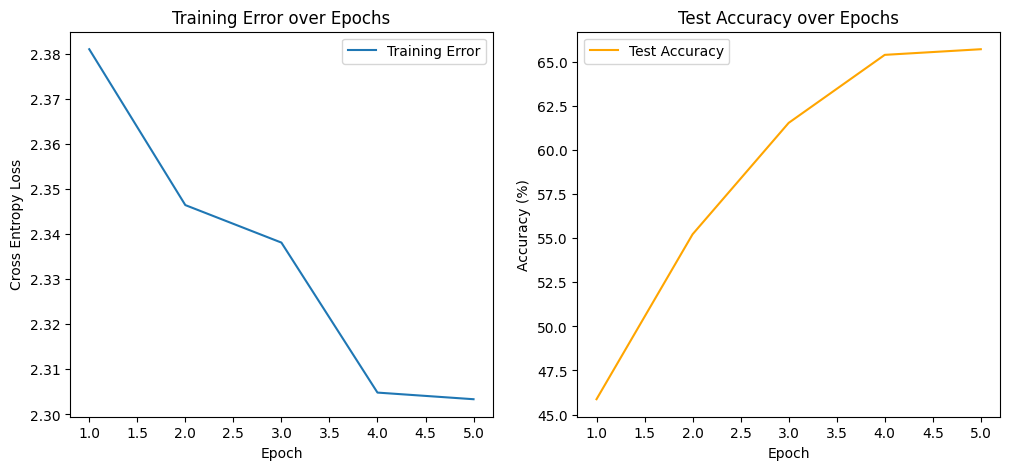

In [ ]:
#@title Part 3.2 Deliverable (3.2.2)
# Save metrics to a CSV file

# Check if all lists have the same length and truncate to the shortest if not
min_length = min(len(train_loss_tracker), len(train_acc_tracker),
                len(test_loss_tracker), len(test_acc_tracker))

results_df = pd.DataFrame({
    'epoch': range(1, min_length + 1),
    'train_loss': train_loss_tracker[:min_length],
    'train_accuracy': train_acc_tracker[:min_length],
    'test_loss': test_loss_tracker[:min_length],
    'test_accuracy': test_acc_tracker[:min_length]
})

# Save CSV
csv_filename = 'part_3_2_training_results.csv'
results_df.to_csv(csv_filename, index=False)
print(f'Training results saved to {csv_filename}')

# Plot the training error and test accuracy
epochs_range = range(1, min_length + 1)

plt.figure(figsize=(12, 5))

# Plot training error (cross-entropy loss)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_tracker[:min_length], label='Training Error')
plt.title('Training Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_acc_tracker[:min_length], label='Test Accuracy', color='orange')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Save the plot as a PNG file
plot_filename = 'part_3_2_training_plot.png'
plt.savefig(plot_filename)
print(f'Training plot saved to {plot_filename}')

# Show the plot
plt.show()

In [ ]:
#@title Pruning Function Definitions (Part 3.3 Pre-Work)
def get_sparse_conv2d_layers(net):
    '''
    Helper function which returns all SparseConv2d layers in the net.
    Use this below to implement layerwise pruning.
    '''
    sparse_conv_layers = []
    for layer in net.children():
        if isinstance(layer, SparseConv2d):
            sparse_conv_layers.append(layer)
        else:
            child_layers = get_sparse_conv2d_layers(layer)
            sparse_conv_layers.extend(child_layers)

    return sparse_conv_layers

def filter_l1_pruning(net, prune_percent):
    '''
    Prunes the filters with the smallest L1-norm in each SparseConv2d layer by
    setting the corresponding elements in the mask to zero.
    '''
    for i, layer in enumerate(get_sparse_conv2d_layers(net)):
       # Shape: [out_channels, in_channels, height, width]
        weight = layer._weight.data

        # Calculate L1-norm for each filter (sum of absolute values)
        # Shape: [out_channels]
        l1_norms = weight.abs().sum(dim=[1, 2, 3])

        # Determine how many filters to prune
        # Number of filters (out_channels)
        num_total = l1_norms.size(0)
        num_prune = round(num_total * prune_percent)  # Number of filters to prune

        if num_prune > 0:
            # Get the indices of the filters with the smallest L1-norms
            _, prune_indices = torch.topk(l1_norms, num_prune, largest=False)

            # Update the mask: set corresponding entries to zero
            layer._mask.data[prune_indices] = 0  # Pruning the filters

        # Calculate and print the current sparsity level
        num_nonzero = layer._mask.sum().item()  # Count non-zero entries in the mask
        sparsity = 100.0 * (1 - (num_nonzero / num_total))  # Sparsity as a percentage
        print(f"Layer {i+1}: Pruned {num_prune}/{num_total} filters, Sparsity: {sparsity:.2f}%")
        print()

In [ ]:
#@title Code Cell 3.3 (Part 3.3.1 and 3.3.2)

torch.manual_seed(43)
device = 'cuda'

net = SparseConvNet()
net = net.to(device)

# Learning rate and optimizer setup
lr = 0.1
milestones = [25, 50, 75]
epochs = 100

# Pruning schedule: Start pruning at epoch 10, prune an additional 10% every 10 epochs until epoch 50
initial_prune_percentage = 0.1  # Start by pruning 10%
prune_epochs = list(range(10, 51, 10))  # Prune at epochs 10, 20, 30, 40, 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)


train_loss_tracker, train_acc_tracker = [], []
test_loss_tracker, test_acc_tracker = [], []

print(f'Training for {epochs} epochs, with learning rate {lr} and milestones {milestones}')

start_time = time.time()

for epoch in range(epochs):

    train(net=net, epoch=epoch, loader=trainloader, criterion=criterion, optimizer=optimizer,
          loss_tracker=train_loss_tracker, acc_tracker=train_acc_tracker)

    # Apply pruning if the current epoch is in the pruning schedule (up to epoch 50)
    if epoch in prune_epochs:
        prune_percentage = initial_prune_percentage * prune_epochs.index(epoch) + initial_prune_percentage
        print(f'Pruning at epoch {epoch}, Prune Percentage: {prune_percentage:.2f}')

        # Structured Pruning
        filter_l1_pruning(net, prune_percentage)

    test(net=net, epoch=epoch, loader=testloader, criterion=criterion,
         loss_tracker=test_loss_tracker, acc_tracker=test_acc_tracker)

    # Step the learning rate scheduler
    scheduler.step()

total_time = time.time() - start_time
print(f'Total training time: {total_time:.2f} seconds')



Training for 100 epochs, with learning rate 0.1 and milestones [25, 50, 75]
Epoch 0: Train Loss: 1.471| Train Acc: 45.534 | Test Loss: 1.279 | Test Acc: 55.170
Epoch 1: Train Loss: 0.976| Train Acc: 65.318 | Test Loss: 1.012 | Test Acc: 65.410
Epoch 2: Train Loss: 0.785| Train Acc: 72.648 | Test Loss: 0.804 | Test Acc: 71.980
Epoch 3: Train Loss: 0.693| Train Acc: 76.146 | Test Loss: 1.121 | Test Acc: 62.360
Epoch 4: Train Loss: 0.634| Train Acc: 78.148 | Test Loss: 0.995 | Test Acc: 67.850
Epoch 5: Train Loss: 0.596| Train Acc: 79.472 | Test Loss: 0.676 | Test Acc: 76.720
Epoch 6: Train Loss: 0.568| Train Acc: 80.436 | Test Loss: 0.625 | Test Acc: 78.160
Epoch 7: Train Loss: 0.548| Train Acc: 81.220 | Test Loss: 0.762 | Test Acc: 74.450
Epoch 8: Train Loss: 0.530| Train Acc: 81.736 | Test Loss: 0.758 | Test Acc: 75.430
Epoch 9: Train Loss: 0.519| Train Acc: 82.274 | Test Loss: 0.823 | Test Acc: 74.320
Epoch 10: Train Loss: 0.506| Train Acc: 82.572Pruning at epoch 10, Prune Percentage:

In [ ]:
#@title Save Performance and Model from Part 3.3.2
import pandas as pd
import os

metrics_filename = 'part_3_3_2_metrics'
model_filename = 'part_3_3_2_model.pth'

def save_metrics_and_model(train_loss_tracker, train_acc_tracker, test_loss_tracker, test_acc_tracker, net):
    # Create a directory to store the metrics if it doesn't exist
    if not os.path.exists(metrics_filename):
        os.makedirs(metrics_filename)

    # Save each metric list as a separate CSV file
    pd.DataFrame(train_loss_tracker, columns=['train_loss']).to_csv(f'{metrics_filename}/train_loss.csv', index=False)
    pd.DataFrame(train_acc_tracker, columns=['train_accuracy']).to_csv(f'{metrics_filename}/train_accuracy.csv', index=False)
    pd.DataFrame(test_loss_tracker, columns=['test_loss']).to_csv(f'{metrics_filename}/test_loss.csv', index=False)
    pd.DataFrame(test_acc_tracker, columns=['test_accuracy']).to_csv(f'{metrics_filename}/test_accuracy.csv', index=False)
    print(f'Metrics saved to {metrics_filename} directory')

    # Save model state_dict
    torch.save(net.state_dict(), model_filename)
    print(f'Model saved to {model_filename}')

# After training is complete, call the function to save metrics and model
save_metrics_and_model(train_loss_tracker, train_acc_tracker, test_loss_tracker, test_acc_tracker, net)

Metrics saved to part_3_3_2_metrics directory
Model saved to part_3_3_2_model.pth


In [ ]:
#@title Baseline model for part 3.3.3 (see writeup)
# requires the baseline model from PART 1.2
# Run this to get test accuracy for baseline ConvNet
# Set up the baseline ConvNet for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net_baseline = ConvNet().to(device)

# Set the training parameters
lr = 0.1  # Learning rate as per Part 1.2
epochs = 100  # Training for 100 epochs
milestones = range(0, epochs, 25)  # Milestones for learning rate decay (as done in Part 1.2)

criterion = nn.CrossEntropyLoss()  # Loss function (Cross Entropy for classification)
optimizer = torch.optim.SGD(net_baseline.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)  # Learning rate decay

# Trackers for loss and accuracy
train_loss_tracker_baseline, train_acc_tracker_baseline = [], []
test_loss_tracker_baseline, test_acc_tracker_baseline = [], []

print(f'Training baseline ConvNet for {epochs} epochs with eta={lr}...')

# Training loop for the baseline ConvNet
start_time_baseline = time.time()
for epoch in range(epochs):
    train(net=net_baseline, epoch=epoch, loader=trainloader, criterion=criterion, optimizer=optimizer, loss_tracker=train_loss_tracker_baseline, acc_tracker=train_acc_tracker_baseline)
    test(net=net_baseline, epoch=epoch, loader=testloader, criterion=criterion, loss_tracker=test_loss_tracker_baseline, acc_tracker=test_acc_tracker_baseline)
    scheduler.step()

total_time_baseline = time.time() - start_time_baseline
print(f'Total training time for baseline ConvNet: {total_time_baseline:.2f} seconds')

# After training, the test accuracy will be stored in `test_acc_tracker_baseline`


Training baseline ConvNet for 100 epochs with eta=0.1...
Epoch 0: Train Loss: 1.462| Train Acc: 46.072 | Test Loss: 1.301 | Test Acc: 53.390
Epoch 1: Train Loss: 0.989| Train Acc: 64.976 | Test Loss: 1.325 | Test Acc: 59.570
Epoch 2: Train Loss: 0.796| Train Acc: 72.018 | Test Loss: 0.960 | Test Acc: 69.210
Epoch 3: Train Loss: 0.687| Train Acc: 76.070 | Test Loss: 0.821 | Test Acc: 73.370
Epoch 4: Train Loss: 0.611| Train Acc: 78.798 | Test Loss: 0.684 | Test Acc: 76.370
Epoch 5: Train Loss: 0.556| Train Acc: 80.818 | Test Loss: 0.671 | Test Acc: 77.020
Epoch 6: Train Loss: 0.516| Train Acc: 82.078 | Test Loss: 0.592 | Test Acc: 80.240
Epoch 7: Train Loss: 0.481| Train Acc: 83.436 | Test Loss: 0.632 | Test Acc: 78.950
Epoch 8: Train Loss: 0.449| Train Acc: 84.430 | Test Loss: 0.624 | Test Acc: 79.560
Epoch 9: Train Loss: 0.426| Train Acc: 85.456 | Test Loss: 0.536 | Test Acc: 82.340
Epoch 10: Train Loss: 0.400| Train Acc: 86.246 | Test Loss: 0.500 | Test Acc: 83.260
Epoch 11: Train Lo

In [ ]:
#@title Save Performance and Model for BASELINE model
import pandas as pd
import torch

# Define file names for saving the metrics and model for baseline ConvNet
baseline_train_loss_filename = 'baseline_train_loss.csv'
baseline_train_acc_filename = 'baseline_train_accuracy.csv'
baseline_test_loss_filename = 'baseline_test_loss.csv'
baseline_test_acc_filename = 'baseline_test_accuracy.csv'
baseline_model_filename = 'baseline_convnet_model.pth'

def save_baseline_metrics_and_model(train_loss_tracker, train_acc_tracker, test_loss_tracker, test_acc_tracker, net):
    # Save metrics to CSV
    pd.DataFrame(train_loss_tracker, columns=['train_loss']).to_csv(baseline_train_loss_filename, index=False)
    pd.DataFrame(train_acc_tracker, columns=['train_accuracy']).to_csv(baseline_train_acc_filename, index=False)
    pd.DataFrame(test_loss_tracker, columns=['test_loss']).to_csv(baseline_test_loss_filename, index=False)
    pd.DataFrame(test_acc_tracker, columns=['test_accuracy']).to_csv(baseline_test_acc_filename, index=False)
    print(f'Baseline ConvNet metrics saved to separate files')

    # Save model state_dict
    torch.save(net.state_dict(), baseline_model_filename)
    print(f'Baseline ConvNet model saved to {baseline_model_filename}')

# After training is complete, call the function to save metrics and model
save_baseline_metrics_and_model(train_loss_tracker_baseline, train_acc_tracker_baseline, test_loss_tracker_baseline, test_acc_tracker_baseline, net_baseline)

Baseline ConvNet metrics saved to separate files
Baseline ConvNet model saved to baseline_convnet_model.pth


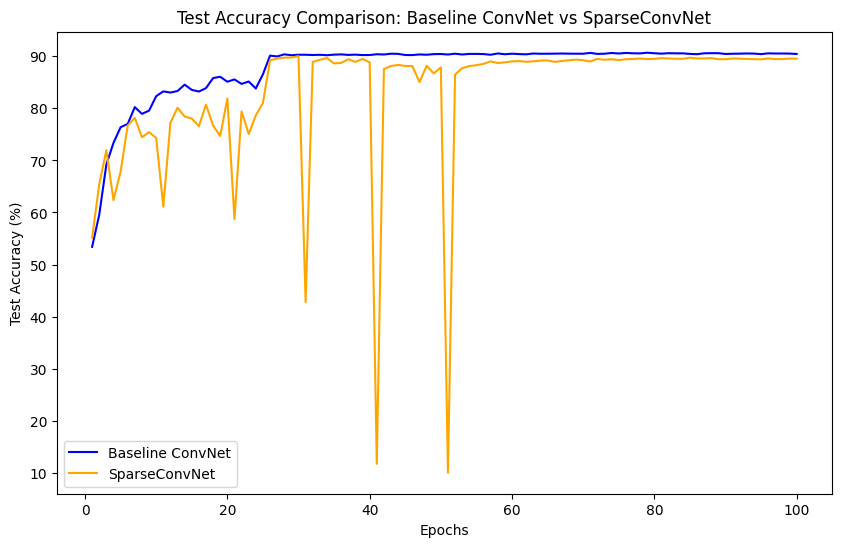

In [ ]:
#@title Part 3.3.3 and 3.3.4 (Graph and Analysis of Test Accuracy)
# Extract test accuracy values from both dataframes
baseline_test_accuracy_df = pd.read_csv('baseline_test_accuracy.csv')
sparseconvnet_test_accuracy_df = pd.read_csv('test_accuracy.csv')

baseline_test_accuracy = baseline_test_accuracy_df['test_accuracy']
sparseconvnet_test_accuracy = sparseconvnet_test_accuracy_df['test_accuracy']

# Create a range for the number of epochs based on the data length
baseline_epochs = range(1, len(baseline_test_accuracy) + 1)
sparseconvnet_epochs = range(1, len(sparseconvnet_test_accuracy) + 1)

# Plot the test accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(baseline_epochs, baseline_test_accuracy, label='Baseline ConvNet', color='blue')
plt.plot(sparseconvnet_epochs, sparseconvnet_test_accuracy, label='SparseConvNet', color='orange')

# Add title and labels
plt.title('Test Accuracy Comparison: Baseline ConvNet vs SparseConvNet')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy (%)')

# Add legend
plt.legend()

# Show the plot
plt.show()

---
<font color='red'>**PART 3.4:**</font> [25 points]

<font color='red'>**Deliverables**</font>
1. Use the `SparseConv2d` (the layer using *unstructured pruning*) in *Code Cell 3.4* to replace the `SparseConv2d` (the layer using *structured pruning*) in *Code Cell 3.1*.
2. Implement the `unstructured_pruning` function in *Code Cell 3.4* and use it to replace the `filter_l1_pruning` function in *Code Cell 3.3*. Or make a copy of *Code Cell 3.3*.
3. Re-run training with `unstructured_pruning` (i.e., *Code Cell 3.1, 3.2, 3.3*). You may make copies of those code cells if that is easier for you.
4. Compare the 3 test accuracy curves among the baseline ConvNet model from <font color='red'>**PART 1.2**</font>, the structured pruning model from <font color='red'>**PART 3.3**</font>, and the unstructured pruning model from <font color='red'>**PART 3.4**</font> in a single plot.
5. Describe any observations in the comparison of structured and unstructured pruning. (150 words maximum)

---

In [ ]:
#@title Code Cell 3.1 (CLONE - Unstructured Pruning)

def _make_pair(x):
    if hasattr(x, '__len__'):
        return x
    else:
        return (x, x)

class SparseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                     padding=1):
        super(SparseConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = _make_pair(stride)
        self.padding = _make_pair(padding)

        # Initialize weights of this layer
        self._weight = nn.Parameter(torch.randn([self.out_channels, self.in_channels,
                                                        self.kernel_size, self.kernel_size]))
        stdv = 1. / math.sqrt(in_channels)
        self._weight.data.uniform_(-stdv, stdv)

        # Initialize mask for unstructured pruning (same size as weight tensor)
        self.register_buffer('_mask', torch.ones_like(self._weight))

    def forward(self, x):
        # Apply the mask to the weights
        return F.conv2d(x, self.weight, stride=self.stride, padding=self.padding)

    @property
    def weight(self):
        # Return the masked weights for convolution
        return self._mask * self._weight

def unstructured_pruning(net, prune_percent):
    for i, layer in enumerate(get_sparse_conv2d_layers(net)):
        num_nonzero = layer._mask.sum().item()
        num_total = layer._mask.numel()
        num_prune = round(num_total * prune_percent)
        sparsity = 100.0 * (1 - (num_nonzero / num_total))
        print(f'Pruning {num_prune}/{num_total} weights, Sparsity: {sparsity:.2f}%')
        print()

        # Flatten the weight tensor and get the absolute values for unstructured pruning
        flat_weights = layer._weight.data.view(-1).abs()

        # Get the indices of the smallest weights (by magnitude)
        _, prune_indices = torch.topk(flat_weights, num_prune, largest=False)

        # Update the mask by zeroing out the pruned weights
        layer._mask.view(-1)[prune_indices] = 0


In [ ]:
#@title Code Cell 3.2 (CLONE - Unstructured Pruning)

def sparse_conv_block(in_channels, out_channels, kernel_size=3, stride=1,
                      padding=1):
    '''
    Replaces 3x3 nn.Conv2d with 3x3 SparseConv2d
    '''
    return nn.Sequential(
        SparseConv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

class SparseConvNet(nn.Module):
    '''
    A 9 layer CNN using the sparse_conv_block function above.
    PART 3.1: Implement!
    '''
    def __init__(self):
        super(SparseConvNet, self).__init__()
        self.model = nn.Sequential(
            sparse_conv_block(3, 32),
            sparse_conv_block(32, 32),
            sparse_conv_block(32, 64, stride=2),
            sparse_conv_block(64, 64),
            sparse_conv_block(64, 64),
            sparse_conv_block(64, 128, stride=2),
            sparse_conv_block(128, 128),
            sparse_conv_block(128, 256),
            sparse_conv_block(256, 256),
            nn.AdaptiveAvgPool2d(1)
            )

        self.classifier = nn.Linear(256, 10)

    def forward(self, x):
        h = self.model(x)
        B, C, _, _ = h.shape
        h = h.view(B, C)
        return self.classifier(h)

In [ ]:
#@title Code Cell 3.3 (CLONE - Unstructured Pruning)

torch.manual_seed(43)
device = 'cuda'

net = SparseConvNet()
net = net.to(device)

# Learning rate and optimizer setup
lr = 0.1
milestones = [25, 50, 75]
epochs = 100

# Pruning schedule: Start pruning at epoch 10, prune an additional 10% every 10 epochs until epoch 50
initial_prune_percentage = 0.1  # Start by pruning 10%
prune_epochs = list(range(10, 51, 10))  # Prune at epochs 10, 20, 30, 40, 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

# Initialize lists to track loss and accuracy
train_loss_tracker, train_acc_tracker = [], []
test_loss_tracker, test_acc_tracker = [], []

print(f'Training for {epochs} epochs, with learning rate {lr} and milestones {milestones}')

start_time = time.time()

for epoch in range(epochs):

    train(net=net, epoch=epoch, loader=trainloader, criterion=criterion, optimizer=optimizer,
          loss_tracker=train_loss_tracker, acc_tracker=train_acc_tracker)

    # Apply pruning if the current epoch is in the pruning schedule (up to epoch 50)
    if epoch in prune_epochs:
        prune_percentage = initial_prune_percentage * prune_epochs.index(epoch) + initial_prune_percentage
        print(f'Pruning at epoch {epoch}, Prune Percentage: {prune_percentage:.2f}')
        print()

        # UNSTRUCTURED PRUNING: changed from structured l1 pruning
        unstructured_pruning(net, prune_percentage)

    # Test after each epoch
    test(net=net, epoch=epoch, loader=testloader, criterion=criterion,
         loss_tracker=test_loss_tracker, acc_tracker=test_acc_tracker)

    # Step the learning rate scheduler
    scheduler.step()

total_time = time.time() - start_time
print(f'Total training time: {total_time:.2f} seconds')



Training for 100 epochs, with learning rate 0.1 and milestones [25, 50, 75]
Epoch 0: Train Loss: 1.455| Train Acc: 46.160 | Test Loss: 1.167 | Test Acc: 58.570
Epoch 1: Train Loss: 0.972| Train Acc: 65.424 | Test Loss: 1.616 | Test Acc: 54.630
Epoch 2: Train Loss: 0.786| Train Acc: 72.454 | Test Loss: 0.975 | Test Acc: 66.380
Epoch 3: Train Loss: 0.701| Train Acc: 75.824 | Test Loss: 0.847 | Test Acc: 70.710
Epoch 4: Train Loss: 0.644| Train Acc: 77.656 | Test Loss: 0.747 | Test Acc: 74.370
Epoch 5: Train Loss: 0.602| Train Acc: 79.372 | Test Loss: 0.812 | Test Acc: 73.110
Epoch 6: Train Loss: 0.575| Train Acc: 80.164 | Test Loss: 0.690 | Test Acc: 77.050
Epoch 7: Train Loss: 0.557| Train Acc: 80.914 | Test Loss: 0.780 | Test Acc: 73.670
Epoch 8: Train Loss: 0.536| Train Acc: 81.648 | Test Loss: 0.647 | Test Acc: 78.490
Epoch 9: Train Loss: 0.519| Train Acc: 82.104 | Test Loss: 0.635 | Test Acc: 78.580
Epoch 10: Train Loss: 0.505| Train Acc: 82.668Pruning at epoch 10, Prune Percentage:

In [ ]:
#@title Part 3.4.3 (Save Metrics and Model Locally)
import pandas as pd
# Define file names for saving each piece of data separately
train_loss_filename = 'unstructured_pruning_train_loss.csv'
train_acc_filename = 'unstructured_pruning_train_acc.csv'
test_loss_filename = 'unstructured_pruning_test_loss.csv'
test_acc_filename = 'unstructured_pruning_test_acc.csv'
model_filename = 'unstructured_pruning_model.pth'

def save_unstructured_pruning_results(train_loss_tracker, train_acc_tracker, test_loss_tracker, test_acc_tracker, net):
    # Save train loss to CSV
    pd.DataFrame({'train_loss': train_loss_tracker}).to_csv(train_loss_filename, index=False)
    print(f'Train loss saved to {train_loss_filename}')

    # Save train accuracy to CSV
    pd.DataFrame({'train_accuracy': train_acc_tracker}).to_csv(train_acc_filename, index=False)
    print(f'Train accuracy saved to {train_acc_filename}')

    # Save test loss to CSV
    pd.DataFrame({'test_loss': test_loss_tracker}).to_csv(test_loss_filename, index=False)
    print(f'Test loss saved to {test_loss_filename}')

    # Save test accuracy to CSV
    pd.DataFrame({'test_accuracy': test_acc_tracker}).to_csv(test_acc_filename, index=False)
    print(f'Test accuracy saved to {test_acc_filename}')

    # Save model state_dict
    torch.save(net.state_dict(), model_filename)
    print(f'Unstructured pruning model saved to {model_filename}')

# After training is complete, call the function to save metrics and model
save_unstructured_pruning_results(train_loss_tracker, train_acc_tracker, test_loss_tracker, test_acc_tracker, net)


Train loss saved to unstructured_pruning_train_loss.csv
Train accuracy saved to unstructured_pruning_train_acc.csv
Test loss saved to unstructured_pruning_test_loss.csv
Test accuracy saved to unstructured_pruning_test_acc.csv
Unstructured pruning model saved to unstructured_pruning_model.pth


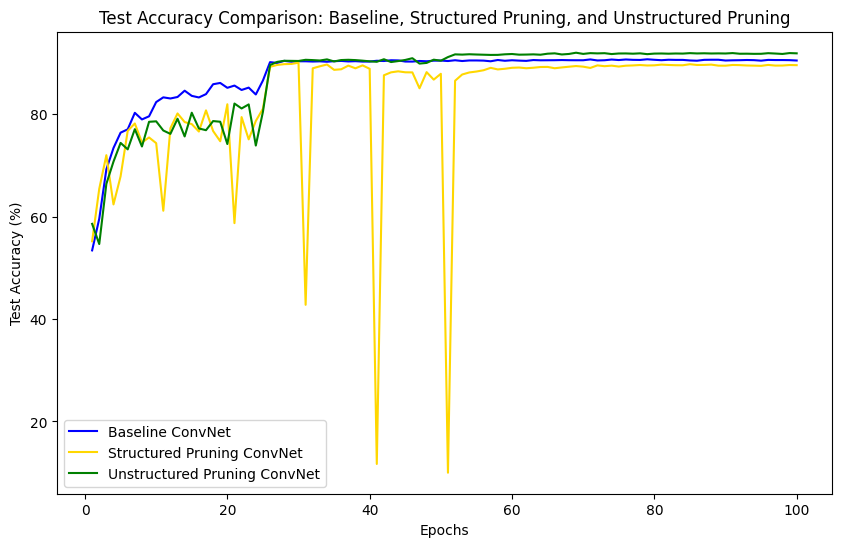

In [ ]:
#@title Part 3.4.4 and 3.4.5 (Visualizations and Analysis)

import pandas as pd
import matplotlib.pyplot as plt

# Load your data (assuming you've already uploaded and saved them locally)
baseline_test_accuracy_df = pd.read_csv('baseline_test_accuracy.csv')
structured_pruning_test_accuracy_df = pd.read_csv('structured_pruning_test_accuracy.csv')
unstructured_pruning_test_accuracy_df = pd.read_csv('unstructured_pruning_test_acc.csv')

# Extract test accuracy values
baseline_test_accuracy = baseline_test_accuracy_df['test_accuracy']
structured_pruning_test_accuracy = structured_pruning_test_accuracy_df['test_accuracy']
unstructured_pruning_test_accuracy = unstructured_pruning_test_accuracy_df['test_accuracy']

# Create a range for the number of epochs based on the data length
epochs_baseline = range(1, len(baseline_test_accuracy) + 1)
epochs_structured = range(1, len(structured_pruning_test_accuracy) + 1)
epochs_unstructured = range(1, len(unstructured_pruning_test_accuracy) + 1)

# Plot the test accuracy curves for all three models
plt.figure(figsize=(10, 6))

plt.plot(epochs_baseline, baseline_test_accuracy, label='Baseline ConvNet', color='blue')
plt.plot(epochs_structured, structured_pruning_test_accuracy, label='Structured Pruning ConvNet', color='#FFD700')
plt.plot(epochs_unstructured, unstructured_pruning_test_accuracy, label='Unstructured Pruning ConvNet', color='green')

# Add title and labels
plt.title('Test Accuracy Comparison: Baseline, Structured Pruning, and Unstructured Pruning')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy (%)')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
#@title Code Cell 3.4

class SparseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                     padding=1):
        super(SparseConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = _make_pair(stride)
        self.padding = _make_pair(padding)

        # initialize weights of this layer
        self._weight = nn.Parameter(torch.randn([self.out_channels, self.in_channels,
                                                        self.kernel_size, self.kernel_size]))
        stdv = 1. / math.sqrt(in_channels)
        self._weight.data.uniform_(-stdv, stdv)
        self.register_buffer('_mask', torch.ones_like(self._weight))


    def forward(self, x):
        return F.conv2d(x, self.weight, stride=self.stride,
                        padding=self.padding)

    @property
    def weight(self):
        return self._mask * self._weight


def unstructured_pruning(net, prune_percent):
    '''
    Prunes weights with the smallest magnitude in each SparseConv2d layer by
    setting the corresponding elements in the mask to zero.
    '''
    for i, layer in enumerate(get_sparse_conv2d_layers(net)):

        num_total = layer._mask.numel()
        num_prune = round(num_total * prune_percent)

        # Get the absolute value of weights, flatten them, and identify smallest weights
        flat_weights = layer._weight.data.view(-1).abs()

        # Get the indices of the smallest weights by magnitude
        _, prune_indices = torch.topk(flat_weights, num_prune, largest=False)

        # Update the mask by setting the smallest weights to zero
        layer._mask.view(-1)[prune_indices] = 0  # Zero out corresponding mask elements

        # Calculate and print the sparsity level
        num_nonzero = layer._mask.sum().item()
        sparsity = 100.0 * (1 - (num_nonzero / num_total))
        print(f'Layer {i+1}: Pruned {num_prune}/{num_total} weights, Sparsity: {sparsity:.2f}%')

---

### **4. Parameter Efficient Fine-tuning**

---

In this section, you will be modifying a model to enable parameter efficient fine-tuning (PEFT).
We will combine two techniques: freezing portions of a model, and applying low-rank updates.


Specifically, you will using the library from [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685).
We recommend reading Section 4 as it describes the method in detail.
LoRA can decrease the computation and memory requirements during training by reducing the number of parameters updated.

Instead of simply applying a full update $\Delta W$ to a frozen weight matrix $W_0 \in R^{d \times k}$, we can represent that update using low-rank decomposition. Namely, $\Delta W = BA$, where $B \in R^{d \times r}$ , $ A \in R^{r \times k}$, and the rank $r << min(d, k)$, resulting in:

$$
W_0 + \Delta W = W_0 + BA
$$

As we are using *low-rank approximation*, it would be more precise to state that $\Delta W \approx BA$, resulting in:

$$
W_0 + \Delta W \approx W_0 + BA
$$


In this section you will be responsible for creating a partially frozen network that applies low-rank updates to a classifier when training on a new [dataset](https://datashare.ed.ac.uk/handle/10283/3192). Code Cells 4.0a-c download and initialize the `cinic-10` dataset, as well as install the [LoRA library](https://github.com/microsoft/LoRA/tree/main).

In summary, you will:
1. Load pre-trained ResNet-18
2. Modify the network to have frozen early layers
3. Further modify the network to have a LoRA classifier layer
4. Compare the fine-tuning performance of: unfrozen, partially frozen, and partially frozen + LoRA models

In [ ]:
#@title Code Cell 4.0a
!mkdir -p data/cinic-10
!curl -L https://datashare.is.ed.ac.uk/bitstream/handle/10283/3192/CINIC-10.tar.gz | tar xz -C data/cinic-10

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   161  100   161    0     0    169      0 --:--:-- --:--:-- --:--:--   169
100  655M  100  655M    0     0  1244k      0  0:08:59  0:08:59 --:--:-- 1028k


In [ ]:
#@title Code Cell 4.0b
cinic_traindir = os.path.join("data", "cinic-10", "train")
cinic_testdir = os.path.join("data", "cinic-10", "test")

cinic_mean = [0.47889522, 0.47227842, 0.43047404]
cinic_std = [0.24205776, 0.23828046, 0.25874835]
cinic_normalize = transforms.Normalize(mean=cinic_mean, std=cinic_std)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cinic_mean, std=cinic_std)
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=cinic_mean, std=cinic_std)
])

c_trainset = datasets.ImageFolder(root=cinic_traindir, transform=train_transform)
c_trainloader = torch.utils.data.DataLoader(c_trainset,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=2)

c_testset = datasets.ImageFolder(root=cinic_testdir, transform=transform)
c_testloader = torch.utils.data.DataLoader(c_testset,
                                         batch_size=100,
                                         shuffle=True,
                                         num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
#@title Code Cell 4.0c
!pip install loralib
import loralib as lora

device = 'cuda'
default_criterion = nn.CrossEntropyLoss
default_epochs = 1
default_lr = 0.01

---
<font color='red'>**PART 4.1:**</font> [25 points]

<font color='red'>**Deliverables**</font>
1. In *Code Cell 4.1*, instantiate a pre-trained ResNet-18 model (`IMAGENET1K_V` weights) using the `torchvision` library.
2. In *Code Cell 4.2*, implement the freezing of earlier layers in the model. As long as the final classification layer is not frozen, you are free to choose whichever layers to freeze. You may want to start with leaving the last 4 conv layers unfrozen.
3. In *Code Cell 4.3*, replace the final classification layer of the ResNet-18 model with a LoRA linear layer.
4. You will train and evaluate the aforementioned models in *Code Cell 4.4* through *Code Cell 4.6*. Plot the test accuracy curves (accuracy vs epoch) on the same graph for these three models: the baseline pre-trained model (`pt_net`), the partially frozen model (`net_freeze`), and the model with both frozen layers and a LoRA classification layer (`net_freeze_lora`). Note: when making adjustments to your models, make sure to run *Code Cells 4.2 - 4.6* **in sequential order** to avoid unexpected results.

---

In [ ]:
#@title Code Cell 4.1

# PART 4.1: Implement!
# Read the documentation at https://pytorch.org/vision/stable/models.html
# Create a Resnet-18 network with weights that were pretrained on IMAGENET1K_V.
from torchvision.models import resnet18 # [ must import resnet18]
# TODO: implement!
pt_net = resnet18(weights="IMAGENET1K_V1")

# Need criterion and optimizer per model
pt_net_criterion = default_criterion()
pt_net_optimizer = torch.optim.SGD(pt_net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Get the baseline accuracy
pt_net.to(device)
test(net=pt_net, epoch=0, loader=c_testloader, criterion=pt_net_criterion, loss_tracker=[], acc_tracker=[])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.6MB/s]


 | Test Loss: 10.426 | Test Acc: 0.017


In [ ]:
#@title Code Cell 4.2

# PART 4.1: Implement!
# Freeze earlier layers of the model (e.g., layer0 -> layerN). [7.5 pts]
# Modifications should be applied to net_freeze.
# Hint: you may want to use the named_parameters() method, and leave biases
# unfrozen.
net_freeze = deepcopy(pt_net)

# Code that freezes layers of network
# layers_to_freeze = ['layer0', 'layer1', 'layer2']  # specify layers to freeze
conv_layers_names = [name for name, module in net_freeze.named_modules() if isinstance(module, nn.Conv2d)][-4:]

for name, param in net_freeze.named_parameters():
    if 'bias' in name:
        continue  # Leave biases unfrozen
    elif any(layer_name in name for layer_name in conv_layers_names):
        param.requires_grad = False

# Need criterion and optimizer per model
net_freeze_criterion = default_criterion()
net_freeze_optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, net_freeze.parameters()), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Get the baseline accuracy
net_freeze.to(device)
test(net=net_freeze, epoch=0, loader=c_testloader, criterion=net_freeze_criterion, loss_tracker=[], acc_tracker=[])

 | Test Loss: 10.426 | Test Acc: 0.017


In [ ]:
#@title Code Cell 4.3

# PART 4.1: Implement!
# Replace the classifer layer with a LoRA linear layer [7.5 pts]
# Modifications should be applied to net_freeze_lora.
# We have already installed and imported this library as "lora"
# Library reference: https://github.com/microsoft/LoRA/tree/main
# Hint: when replacing the layer, you may want to keep a copy of the original
# weights. You may also want try different ranks (but r=10 should suffice).
net_freeze_lora = deepcopy(net_freeze)

# Modify network to have a LoRA linear classifer
# TODO: implement!
last_layer = net_freeze.fc
original_weight = last_layer.weight.data.clone()
original_bias = last_layer.bias.data.clone() if last_layer.bias is not None else None
r = 10
net_freeze.fc = lora.Linear(
    in_features=last_layer.in_features,
    out_features=last_layer.out_features,
    r=r,
    lora_alpha=1.0,
    lora_dropout=0.0,
    bias=(last_layer.bias is not None)
)
net_freeze.fc.weight.data = original_weight.clone()
if original_bias is not None:
    net_freeze.fc.bias.data = original_bias.clone()

# Need criterion and optimizer per model
net_freeze_lora_criterion = default_criterion()
net_freeze_lora_optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, net_freeze_lora.parameters()), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Get the baseline accuracy
net_freeze_lora.to(device)
test(net=net_freeze_lora, epoch=0, loader=c_testloader, criterion=net_freeze_lora_criterion, loss_tracker=[], acc_tracker=[])

 | Test Loss: 10.426 | Test Acc: 0.017


---
<font color='red'>**PART 4.2:**</font> [10 points]

<font color='red'>**Deliverables**</font>
1. You will train and evaluate the aforementioned models in *Code Cell 4.4* through *Code Cell 4.6*. Plot the test accuracy curves (accuracy vs epoch) on the same graph for these three models: the baseline pre-trained model (`pt_net`), the partially frozen model (`net_freeze`), and the model with both frozen layers and a LoRA classification layer (`net_freeze_lora`). Note: if you make any adjustments to your models, make sure to run *Code Cells 4.1 - 4.3* in **sequential order and before** *Code Cells 4.4 - 4.6* to avoid unexpected behavior.
---


In [ ]:
#@title Code Cell 4.4

# Fine-tune and test vanilla pre-trained network
pt_net.to(device)
train_loss_tracker_pt = []
train_acc_tracker_pt = []
test_loss_tracker_pt = []
test_acc_tracker_pt = []
for epoch in range(8): # default_epochs=1 which doesn't make sense... 100 would be far too long so 8 it is
    train(net=pt_net, epoch=epoch, loader=c_trainloader,
          criterion=pt_net_criterion, optimizer=pt_net_optimizer,
          loss_tracker=train_loss_tracker_pt, acc_tracker=train_acc_tracker_pt)
    test(net=pt_net, epoch=epoch, loader=c_testloader,
         criterion=pt_net_criterion,
         loss_tracker=test_loss_tracker_pt, acc_tracker=test_acc_tracker_pt)


Epoch 0: Train Loss: 1.503| Train Acc: 47.342 | Test Loss: 1.667 | Test Acc: 49.593
Epoch 1: Train Loss: 1.226| Train Acc: 56.434 | Test Loss: 1.360 | Test Acc: 59.288
Epoch 2: Train Loss: 1.063| Train Acc: 62.344 | Test Loss: 1.000 | Test Acc: 64.764
Epoch 3: Train Loss: 0.997| Train Acc: 64.639 | Test Loss: 0.942 | Test Acc: 66.619
Epoch 4: Train Loss: 0.945| Train Acc: 66.359 | Test Loss: 0.967 | Test Acc: 65.860
Epoch 5: Train Loss: 0.923| Train Acc: 67.313 | Test Loss: 0.902 | Test Acc: 68.050
Epoch 6: Train Loss: 0.891| Train Acc: 68.469 | Test Loss: 0.911 | Test Acc: 67.779
Epoch 7: Train Loss: 0.874| Train Acc: 68.953 | Test Loss: 0.935 | Test Acc: 66.693


In [ ]:
fig = plt.figure()
fig.tight_layout()
fig.suptitle("Pretrained Resnet-18", y=1, fontweight="bold")
fig.subplots_adjust(top=0.95,hspace=0.4)

ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(train_loss_tracker_pt, label="Training Loss")
ax1.plot(test_loss_tracker_pt, label="Testing Loss")
ax1.xaxis.set_label_text("Sample by Epoch")
ax1.yaxis.set_label_text("Loss (bits)")
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(train_acc_tracker_pt, label="Training Accuracy")
ax2.plot(test_acc_tracker_pt, label="Testing Acccuracy")
ax2.xaxis.set_label_text("Sample by Epoch")
ax2.yaxis.set_label_text("Accuracy (%)")

In [ ]:
#@title Code Cell 4.5

# Fine-tune and test partially frozen network
train_loss_tracker_pf = []
train_acc_tracker_pf = []
test_loss_tracker_pf = []
test_acc_tracker_pf = []
net_freeze.to(device)
for epoch in range(8):
    train(net=net_freeze, epoch=epoch, loader=c_trainloader,
          criterion=net_freeze_criterion, optimizer=net_freeze_optimizer,
          loss_tracker=train_loss_tracker_pf, acc_tracker=train_acc_tracker_pf)
    test(net=net_freeze, epoch=epoch,
         loader=c_testloader, criterion=net_freeze_criterion,
         loss_tracker=test_loss_tracker_pf, acc_tracker=test_acc_tracker_pf)


Epoch 0: Train Loss: 2.262| Train Acc: 39.598 | Test Loss: 1.415 | Test Acc: 53.203
Epoch 1: Train Loss: 1.277| Train Acc: 56.668 | Test Loss: 2.285 | Test Acc: 41.566
Epoch 2: Train Loss: 1.274| Train Acc: 56.093 | Test Loss: 1.123 | Test Acc: 61.432
Epoch 3: Train Loss: 1.094| Train Acc: 62.076 | Test Loss: 1.055 | Test Acc: 63.599
Epoch 4: Train Loss: 1.029| Train Acc: 64.124 | Test Loss: 1.088 | Test Acc: 63.522
Epoch 5: Train Loss: 0.992| Train Acc: 65.499 | Test Loss: 0.993 | Test Acc: 65.630
Epoch 6: Train Loss: 0.957| Train Acc: 66.534 | Test Loss: 0.966 | Test Acc: 66.576
Epoch 7: Train Loss: 0.930| Train Acc: 67.351 | Test Loss: 0.939 | Test Acc: 66.924


In [ ]:
#@title Code Cell 4.6

# Fine-tune and test partially frozen network with LoRA classifier
train_loss_tracker_pfl = []
train_acc_tracker_pfl = []
test_loss_tracker_pfl = []
test_acc_tracker_pfl = []
net_freeze_lora.to(device)
for epoch in range(8):
    train(net=net_freeze_lora, epoch=epoch, loader=c_trainloader,
          criterion=net_freeze_lora_criterion, optimizer=net_freeze_lora_optimizer,
          loss_tracker=train_loss_tracker_pfl, acc_tracker=train_acc_tracker_pfl)
    test(net=net_freeze_lora, epoch=epoch,
         loader=c_testloader, criterion=net_freeze_lora_criterion,
         loss_tracker=test_loss_tracker_pfl, acc_tracker=test_acc_tracker_pfl)


Epoch 0: Train Loss: 1.694| Train Acc: 39.347 | Test Loss: 1.296 | Test Acc: 53.607
Epoch 1: Train Loss: 1.211| Train Acc: 56.538 | Test Loss: 1.261 | Test Acc: 57.593
Epoch 2: Train Loss: 1.087| Train Acc: 61.192 | Test Loss: 1.058 | Test Acc: 62.612
Epoch 3: Train Loss: 1.022| Train Acc: 63.731 | Test Loss: 1.086 | Test Acc: 62.850
Epoch 4: Train Loss: 0.968| Train Acc: 65.709 | Test Loss: 0.989 | Test Acc: 65.142
Epoch 5: Train Loss: 0.938| Train Acc: 66.757 | Test Loss: 0.986 | Test Acc: 64.964
Epoch 6: Train Loss: 0.930| Train Acc: 67.052 | Test Loss: 0.924 | Test Acc: 67.166
Epoch 7: Train Loss: 0.898| Train Acc: 68.183 | Test Loss: 0.973 | Test Acc: 66.211


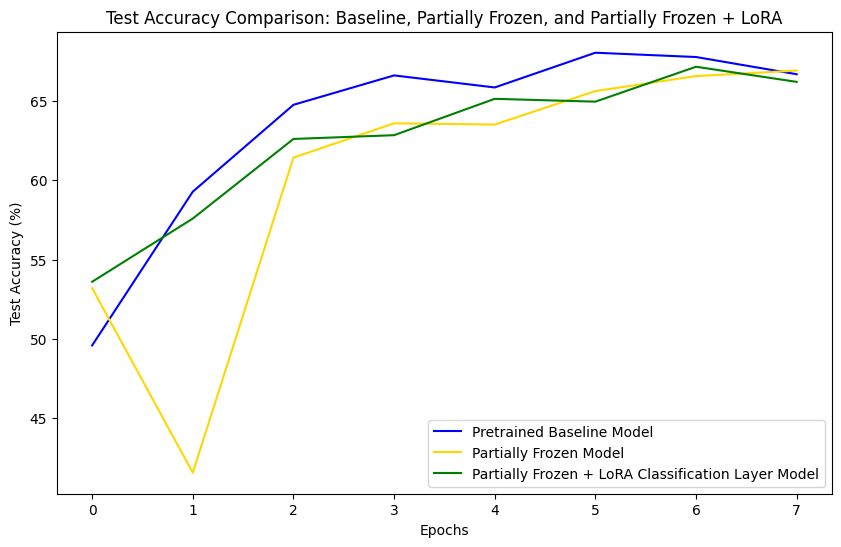

In [ ]:
# Code for plotting the accuracy vs. epoch for all 3 models

plt.figure(figsize=(10, 6))

plt.plot(test_acc_tracker_pt, label='Pretrained Baseline Model', color='blue')
plt.plot(test_acc_tracker_pf, label='Partially Frozen Model', color='#FFD700')
plt.plot(test_acc_tracker_pfl, label='Partially Frozen + LoRA Classification Layer Model', color='green')

# Add title and labels
plt.title('Test Accuracy Comparison: Baseline, Partially Frozen, and Partially Frozen + LoRA')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy (%)')

# Add legend
plt.legend()

# Show the plot
plt.show()


---

### **5. Transformers**

---

In [ ]:
#@title Code Cell 5.1

import numpy as np
import matplotlib.pyplot as plt
import time
import logging

import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)
np.random.seed(0)

In this question, your team will be implementing the transformer model, focusing on the original transformer model introduced in the paper "Attention is All You Need" by Vaswani et al. (2017).

In this programming assignment, your team will implement all the components of the transformer model. In the next programming assignment, you will use the components you have implemented here to train a small language model. For this, your team has the option to use PyTorch or TensorFlow for implementation (For Tensorflow, make sure to replace the class definitions).

You will find Figure 1 in the paper very helpful for this problem set. Be sure to carefully review relevant PyTorch/TensorFlow documentation. In your writeup, you will need to write and justify the hyperparameters that you will need to implement the transformer model.

<img src="https://drive.google.com/uc?export=view&id=1TX5V8DRzYlGFv0OMoE6qcW8f-tM5WDH5" width="500"/>


# I: Implementing Components of the Transformer

## 1) Positional Encoding and Embedding
---

**a)** Positional Encoding

The input to the transformer model is just the set of vectors without any notion of order. Without recurrent or convolutional layers we need to inject some information about the position of the words in the sentence. If this is not done, the set of words "I am a student" and "am I a student" would be treated as the same input.

In the original transformer model, the authors use the positional encoding of the form:

$$PE_{(pos, 2i)} = sin(pos / 10000^{2i/d_{model}})$$
$$PE_{(pos, 2i+1)} = cos(pos / 10000^{2i/d_{model}})$$

where $pos$ is the position and $i$ is the dimension. Implement this positional encoding function below.

In [ ]:
#@title Code Cell 5.2

def positional_encoding(length, depth):
  # TODO: IMPLEMENT!
  # Length of the input is `length`, transforming to depth for dot product
  PE = np.zeros((length, depth))
  for pos in range(length):
    for i in range(0, depth, 2):
      denom = np.power(10000, i / depth)
      PE[pos][i] = np.sin(pos / denom)
      PE[pos][i + 1] = np.cos(pos / denom)
  return PE


**b)** Plot the positional encoding with length 2048 and depth 256. Comment on your observations.

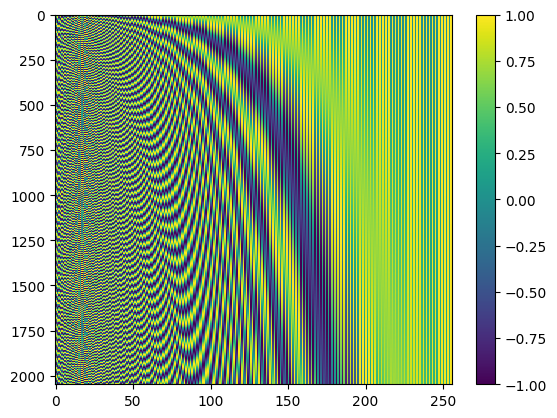

In [ ]:
#@title Code Cell 5.3

fig, ax = plt.subplots()
im = ax.imshow(positional_encoding(2048, 256), aspect="auto", interpolation="none")
plt.colorbar(im, ax=ax)


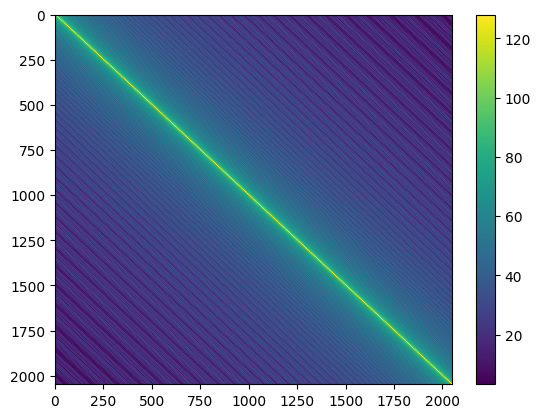

In [ ]:
# Demonstration that the positional encoding is linear when it comes to relative offsets
fig, ax = plt.subplots()
im = ax.imshow(np.matmul(positional_encoding(2048, 256), positional_encoding(2048, 256).T), aspect="auto", interpolation="none")
plt.colorbar(im, ax=ax)

**c)** Now, construct `PositionalEmbedding` class that finds the embedding vector of the token and adds the positional encoding to it. `You may use the torch.nn.Embedding`/`tf.keras.layers.Embedding` layer to find the token embedding.

In [ ]:
#@title Code Cell 5.4
class PositionalEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model, max_len=2048):
      super().__init__()
      # TODO: IMPLEMENT!
      self.encoding = positional_encoding(max_len, d_model)
      self.token_embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
      # TODO: IMPLEMENT!
      token_embeds = self.token_embedding(x)
      positional_enc = self.encoding[:x.size(1), :]
      return token_embeds + torch.tensor(positional_enc, dtype=torch.float)

In [ ]:
#@title Code Cell 5.5
vocab_size = 10
d_model = 16
max_len = 20

model = PositionalEmbedding(vocab_size, d_model, max_len=max_len)

input_tensor = torch.randint(0, vocab_size, (2, 5))

output = model(input_tensor)


print("Input Tensor Shape:")
print(input_tensor.shape)

print("\nOutput Tensor Shape:")
print(output.shape)


def test_positional_embedding_shape():
    expected_shape = (2, 5, d_model)
    assert output.shape == expected_shape, f"Expected shape {expected_shape}, but got {output.shape}"

# Running the test
test_positional_embedding_shape()
print("\nShape test passed!")

Input Tensor Shape:
torch.Size([2, 5])

Output Tensor Shape:
torch.Size([2, 5, 16])

Shape test passed!


## 2) Attention Layers

The Attention mechanism is at the center of the transformer architecture. Recall that the self-attention output is defined as:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
\quad \text{(1)}
$$

where $Q$, $K$, and $V$ are the query, key, and value matrices, respectively. $d_k$ is the dimension of each of the key vectors, and it helps with normalizing dot products that can become large. Here is a short intuition for each of them:

- **Query (Q)** represents something that is looking to gather information, indicating which information is important to the model.

- **Key (K)** represents the information that is being looked at, indicating which information is important to the model.

- **Value (V)** represents the information that is being outputted/passed along.


This allows us to define the multi-head attention, which concatenates different attention layer, allowing the model to focus on different representations of the input in different positions. We define the multi-head attention as follows:

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h)W^O
\quad \text{(2)}
$$

where each head is defined as:

$$
\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
\quad \text{(3)}
$$

where $W_i^Q$, $W_i^K$, and $W_i^V$ are the weight matrices for the query, key, and value vectors, respectively. $W^O$ is the weight matrix that is applied to the concatenated output of the heads.



The Query, Key, and Value vectors are determined by multiplying the input embedding matrix with the weight matrices $W^Q$, $W^K$, and $W^V$, respectively. These are the parameters that are learned during the training process.






**a)** The global self-attention layer processes context sequence and is designed to capture the dependencies between the words in the sequence. For the attention layer equation (2), we know that the input to each of the heads in the multi-head attention are determined by the following:

\begin{equation}
XW^Q, \quad K = XW^K, \quad V = XW^V
\end{equation}

respectively, where $X$ is the input embedding matrix. From this, implement the `GlobalSelfAttention` class. Ensure within the global-self attention layer, you add the normalization and the skip connection. **This will need to be done for all the attention layers you implement in the problem set.** Note that you are **allowed** to use the **torch.nn.MultiheadAttention** class or TensorFlow equivalent.


<img src="https://drive.google.com/uc?export=view&id=1PoY5zupGP46K6fs0qJMDynzJecBBmT0s" width="500"/>

In [ ]:
#@title Code Cell 5.6
class GlobalSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout, **kwargs):
        super().__init__()
        # TODO: IMPLEMENT!
        self.multihead_attention = nn.MultiheadAttention(embed_dim, num_heads, dropout)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # TODO: IMPLEMENT!
        attn_out, _ = self.multihead_attention(x, x, x)
        x = x + attn_out
        x = self.norm(x)
        return x



**b)** The cross attention layer connects the encoder and the decoder together. Implement the `CrossAttention` class, paying attention to the fact that the query comes from the decoder, while the key and value come from the encoder. (So in your call function, you will have 2 inputs)


<img src="https://drive.google.com/uc?export=view&id=1s54R7qkXE8hXgn9XnPGD7sYUFKR08RLV" width="500"/>

In [ ]:
#@title Code Cell 5.7
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout, **kwargs):
        super().__init__()
        # TODO: IMPLEMENT!
        self.multihead_attention = nn.MultiheadAttention(embed_dim, num_heads, dropout)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x, context):
        # TODO: IMPLEMENT!
        attn_out, _ = self.multihead_attention(x, context, context)
        x = x + attn_out
        x = self.norm(x)
        return x



**c)** The causal self-attention layer is similar to the global self-attention layer we discussed in (a), but it is designed for the decoder. To prevent the model from looking into the future, we apply a causal mask to the attention weights, ensuring that the model only attends to the previous tokens. Implement the `CausalSelfAttention` class below.


<img src="https://drive.google.com/uc?export=view&id=1pXMWcB-lIWjRtFxjBTZ73S9Mn1PE-YLc" width="500"/>

In [ ]:
#@title Code Cell 5.8
class CausalSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout, **kwargs):
        super().__init__()
        # TODO: IMPLEMENT!
        self.multihead_attention = nn.MultiheadAttention(embed_dim, num_heads, dropout)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # TODO: IMPLEMENT!
        sequence_length = x.size(0)
        causal_mask = torch.triu(torch.ones(sequence_length, sequence_length), diagonal=1).bool().to(x.device)
        attn_out, _ = self.multihead_attention(x, x, x, attn_mask=causal_mask)
        x = x + attn_out
        x = self.norm(x)
        return x

# 3) Additional Layers - Feedforward and Layer Normalization

After the attention layers in the encoder and the decoder, we have a simple feedforward neural network. It consists of two linear transformations with a ReLU activation in between, and a dropout layer (with dropout rate 0.1) after the linear transformations.

**Implement this network**, and add the layer normalization and the residual connection to the feedforward network.


In [ ]:
#@title Code Cell 5.9
class FeedForward(nn.Module):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        # TODO: IMPLEMENT!
        # dff is the dimension of the hidden layer in the feedforward network.

        self.linear1 = nn.Linear(d_model, dff)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(dff, d_model)
        self.dropout = nn.Dropout(dropout_rate)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        # TODO: IMPLEMENT!
        l1 = self.linear1(x)
        r1 = self.relu(l1)
        l2 = self.linear2(r1)
        out = self.dropout(l2)
        out = x + out
        out = self.norm(x)
        return out


# II Implementing the Transformer Model

## 1) Encoder
---

**a)** Now, we have all the components we need to construct the transformer model. We will start by implementing the encoder layer that consists global self attention and feedforward network. Implement the `EncoderLayer` class below.


In [ ]:
#@title Code Cell 5.10
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        # TODO: IMPLEMENT!
        self.global_attention = GlobalSelfAttention(d_model, num_heads, dropout_rate)
        self.feed_forward = FeedForward(d_model, dff, dropout_rate)

    def forward(self, x):
        # TODO: IMPLEMENT!
        a1 = self.global_attention(x)
        x = self.feed_forward(a1)
        return x


**b)** Implement the `Encoder` class that stacks multiple encoder layers.

In [ ]:
#@title Code Cell 5.11
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads,
                 dff, vocab_size, dropout_rate=0.1):
        super().__init__()
        # TODO: IMPLEMENT!
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)])


    def forward(self, x):
        # TODO: IMPLEMENT!
        out = x
        for layer in self.encoder_layers: out = layer(out)
        return out

## 2) Decoder
---

**a)** Implement the `DecoderLayer` class that consists of causal self attention, cross attention, and feedforward network.

In [ ]:
#@title Code Cell 5.12
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        # TODO: IMPLEMENT!
        self.masked_attention = CausalSelfAttention(d_model, num_heads, dropout_rate)
        self.cross_attention = CrossAttention(d_model, num_heads, dropout_rate)
        self.feed_forward = FeedForward(d_model, dff, dropout_rate)

    def forward(self, x, context):
        # TODO: IMPLEMENT!
        ma = self.masked_attention(x)
        ca = self.cross_attention(ma, context)
        ff = self.feed_forward(ma)
        return ff

**b)** Implement the `Decoder` class that stacks multiple decoder layers.

In [ ]:
#@title Code Cell 5.13
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()
        # TODO: IMPLEMENT!
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)])

    def forward(self, x, context):
        # TODO: IMPLEMENT!
        out = x
        for layer in self.decoder_layers: out = layer(out, context)
        return out

## 3) Transformer - Putting it all together
---
We now have the encoder and the decoder ready, all you have to do is to put them together and add a final dense layer with a softmax activation to get the output. Implement the `Transformer` class below.

In [ ]:
#@title Code Cell 5.14
class Transformer(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super(Transformer, self).__init__()
        # TODO: IMPLEMENT!
        self.input_pos_embedding = PositionalEmbedding(input_vocab_size, d_model)
        self.output_pos_embedding = PositionalEmbedding(target_vocab_size, d_model)
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, dropout_rate)
        self.linear = nn.Linear(d_model, target_vocab_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, context, x):
        # TODO: IMPLEMENT!
        input_emb = self.input_pos_embedding(context).transpose(0,1)
        output_emb = self.output_pos_embedding(x).transpose(0,1)
        enc = self.encoder(input_emb)
        dec = self.decoder(output_emb, input_emb).transpose(0,1)
        out = self.linear(dec)
        out = self.softmax(out)
        return out

Run the test function below to make sure your Transformer can initialize properly and the dimensions work out.

In [ ]:
# @title Test Cell
def run_test():
    # Transformer hyperparameters
    num_layers = 4
    d_model = 512
    num_heads = 8
    dff = 2048
    input_vocab_size = 8000
    target_vocab_size = 8001
    dropout_rate = 0.1

    transformer_model = Transformer(num_layers, d_model, num_heads, dff,
                                    input_vocab_size, target_vocab_size, dropout_rate)

    batch_size = 64
    context_len = 201
    target_len = 200

    context = torch.randint(0, input_vocab_size, (batch_size, context_len))
    x = torch.randint(0, target_vocab_size, (batch_size, target_len))

    print(context.shape)

    logits = transformer_model(context, x)

    print(f"logits shape: {logits.shape}")
    assert logits.shape == (batch_size, target_len, target_vocab_size), \
        f"Expected shape {(batch_size, target_len, target_vocab_size)}, but got {logits.shape}"

run_test()

torch.Size([64, 201])
logits shape: torch.Size([64, 200, 8001])
